# OOS Predictive Performance of SLOPE

## Outline of the steps in this section:
In here, trading strategy with straddles is looked at

- Note cumulative returns for two trading strategies using S&P500 straddles.
    1) Unconditionally selling S&P500 straddles with a constant maturity of 30 days 
        Calculate the returns slightly different: r_shortStraddle = (straddle_t - straddle_t+1)/(0.2 * SP500_t)
        So I need to interpolate a bit different
        Should be substantially positive --> make graph, calculate sharpe ratio, average return and volatility
    2) Conditional strategy using SLOPE as an indicator for whether to buy or sell straddles.
        For 1996 - 1999 training period:
        Compute SLOPE_t using PCA on VIX term structure data from beginning of sample to t
        If SLOPE_t in bottom quintile of historical distribution, buy straddles at t, sell at t+1. Otherwise, short at t, buy             back at t+1
        Should be substantially positive --> make graph, calculate sharpe ratio, average return and volatility
Compare the two strategies, mark in graph where it is different, maybe even a line with the spot price
Play around with the training / test window
What happens when we take another model than PCA?
Exclude Financial crisis? 
Effect Covid?
Own strategy? short 30 day, long 360 day and otherway around? compare sharpe_ratio

In [56]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pandas as pd
import numpy as np
import sqlalchemy as db
import sys
from scipy.interpolate import interp1d
import os
from datetime import datetime, timedelta
from scipy.stats import norm
import math
import matplotlib.dates as mdates

## First step is to create the short straddle returns (adjusted by the 20% margin)
This Dataset is saved and can therefore be skipped. Load it further below.
Note that there are two files saved: one with the correct weighting and one with the incorrect weighting. The name differs accordingly.
For the short straddle returns, the correlation to his given data is higher for the correct weighting (in contrast to the long straddle returns, where it is the other way around). 

In [57]:
# File paths for the CSV files
file_path = 'Data/Straddles/full_atm_data.csv'

# Reading the CSV files into Pandas DataFrames
option_df = pd.read_csv(file_path)

In [58]:
#get straddle prices today and tomorrow based on the respective deltas of the calls and puts
#this section is reused from make_straddle_returns, where the normal straddle returns have been calculated
#based on zero delta
def calculate_straddle_price(row, n):
    total_delta = abs(row['delta_c']) + abs(row['delta_p'])
    w2 = abs(row['delta_c']) / total_delta  # Calculate weights so we have a delta of zero
    w1 = abs(row['delta_p']) / total_delta
    if n == 1:
        return w1*row['call_price']+w2*row['put_price']
    else:
        return w1*row['next_call_price']+w2*row['next_put_price']

# apply the function to every row (every date)
option_df['current_straddle_price'] = option_df.apply(lambda row: calculate_straddle_price(row, 1), axis=1)
option_df['next_straddle_price'] = option_df.apply(lambda row: calculate_straddle_price(row, 2), axis=1)
# Selecting specific columns and creating a new DataFrame
new_df = option_df[['date', 'days_to_exp', 'current_straddle_price', 'next_straddle_price', 'spotprice']].copy()
new_df

,date,days_to_exp,current_straddle_price,next_straddle_price,spotprice
0,1996-01-04,16,5.757318,5.109840,617.70
1,1996-01-04,44,9.137655,9.079675,617.70
2,1996-01-04,72,11.867779,12.087773,617.70
3,1996-01-04,170,19.602408,19.529090,617.70
4,1996-01-05,15,5.316093,4.830802,616.71
...,...,...,...,...,...
100036,2023-02-27,291,272.506327,267.009695,3982.24
100037,2023-02-27,305,265.404985,261.572730,3982.24
100038,2023-02-27,326,280.863293,275.551640,3982.24
100039,2023-02-27,354,298.541904,293.474002,3982.24


In [62]:
# now with the straddle prices, calculate the constant maturity straddle price for today and tomorrow and save it
# check the weighting! for the short straddles, the correlation to his data is higher when we use the correct weighting

def interpolate_straddle_price(T, df):
    df['date'] = pd.to_datetime(df['date'])  # Convert 'date' column to datetime if it's stored as a string
    unique_dates = df['date'].drop_duplicates()
    straddle_price_data = []
    for date_value in unique_dates:
        subset_df = df[df['date'] == date_value].copy()
        date_value = date_value.strftime("%Y-%m-%d")
        exact_day = subset_df[subset_df['days_to_exp'] == T]
        #next_day = df.loc[df['date'] > date_value, 'date'].min()
        if not exact_day.empty:
            straddle_price_data.append({
                'date': date_value,
                'spot_price': exact_day['spotprice'].iloc[0],
                f"current_straddle_price_{T}": exact_day['current_straddle_price'].iloc[0],
                f"next_straddle_price_{T}": exact_day['next_straddle_price'].iloc[0]
            })
        else:
            subset_df['days_diff'] = abs(subset_df['days_to_exp'] - T)
            nearest_two = subset_df.nsmallest(2, 'days_diff').sort_values('days_to_exp')
            S1 = nearest_two.iloc[0]
            S2 = nearest_two.iloc[1]
            #wrong weighting
            #price_t1 = (abs(S1['days_to_exp'] - T) / abs(S2['days_to_exp'] - S1['days_to_exp'])) * S1['next_straddle_price'] + (abs(T - S2['days_to_exp']) / abs(S2['days_to_exp'] - S1['days_to_exp'])) * S2['next_straddle_price']
            #price_t = (abs(S1['days_to_exp'] - T) / abs(S2['days_to_exp'] - S1['days_to_exp'])) * S1['current_straddle_price'] + (abs(T - S2['days_to_exp']) / abs(S2['days_to_exp'] - S1['days_to_exp'])) * S2['current_straddle_price']
            #correct weighting
            price_t1 = (abs(T - S2['days_to_exp']) / abs(S2['days_to_exp'] - S1['days_to_exp'])) * S1['next_straddle_price'] + (abs(S1['days_to_exp'] - T) / abs(S2['days_to_exp'] - S1['days_to_exp'])) * S2['next_straddle_price']
            price_t = (abs(T - S2['days_to_exp']) / abs(S2['days_to_exp'] - S1['days_to_exp'])) * S1['current_straddle_price'] + (abs(S1['days_to_exp'] - T) / abs(S2['days_to_exp'] - S1['days_to_exp'])) * S2['current_straddle_price']
            straddle_price_data.append({
                'date': date_value,
                'spot_price': S1['spotprice'],
                f"current_straddle_price_{T}": price_t,
                f"next_straddle_price_{T}": price_t1
            })

    return pd.DataFrame(straddle_price_data)


In [63]:
# apply this function and save the results for all necessary maturities
results_30 = interpolate_straddle_price(30, new_df)
results_30['r_v_30'] = (results_30['current_straddle_price_30'] - results_30['next_straddle_price_30']) / (0.2 * results_30['spot_price'])
results_30['r_v_30'] = results_30['r_v_30'].shift(1)

results_60 = interpolate_straddle_price(60, new_df)
results_60['r_v_60'] = (results_60['current_straddle_price_60'] - results_60['next_straddle_price_60']) / (0.2 * results_60['spot_price'])
results_60['r_v_60'] = results_60['r_v_60'].shift(1)

results_90 = interpolate_straddle_price(90, new_df)
results_90['r_v_90'] = (results_90['current_straddle_price_90'] - results_90['next_straddle_price_90']) / (0.2 * results_90['spot_price'])
results_90['r_v_90'] = results_90['r_v_90'].shift(1)

results_180 = interpolate_straddle_price(180, new_df)
results_180['r_v_180'] = (results_180['current_straddle_price_180'] - results_180['next_straddle_price_180']) / (0.2 * results_180['spot_price'])
results_180['r_v_180'] = results_180['r_v_180'].shift(1)

results_270 = interpolate_straddle_price(270, new_df)
results_270['r_v_270'] = (results_270['current_straddle_price_270'] - results_270['next_straddle_price_270']) / (0.2 * results_270['spot_price'])
results_270['r_v_270'] = results_270['r_v_270'].shift(1)

results_360 = interpolate_straddle_price(360, new_df)
results_360['r_v_360'] = (results_360['current_straddle_price_360'] - results_360['next_straddle_price_360']) / (0.2 * results_360['spot_price'])
results_360['r_v_360'] = results_360['r_v_360'].shift(1)

# save the results concisely
merged_results = results_30[['date','spot_price', 'r_v_30']].merge(results_60[['date', 'r_v_60']], on='date')
merged_results = merged_results.merge(results_90[['date', 'r_v_90']], on='date')
merged_results = merged_results.merge(results_180[['date', 'r_v_180']], on='date')
merged_results = merged_results.merge(results_270[['date', 'r_v_270']], on='date')
merged_results = merged_results.merge(results_360[['date', 'r_v_360']], on='date')
merged_results = merged_results.drop(['spot_price'], axis=1)
merged_results = merged_results.rename(columns={'date': 'Date'})
merged_results = merged_results.dropna()
merged_results

,Date,r_v_30,r_v_60,r_v_90,r_v_180,r_v_270,r_v_360
1,1996-01-05,0.002855,-0.000495,-0.000374,-0.001902,-0.002992,-0.004083
2,1996-01-08,0.003142,0.002154,0.005123,0.002513,0.001727,0.002332
3,1996-01-09,-0.022605,-0.015655,-0.039804,-0.009084,-0.007066,-0.021692
4,1996-01-10,-0.007527,-0.007223,-0.017653,-0.002057,-0.003246,-0.007708
5,1996-01-11,0.008899,0.006616,0.018454,0.006573,0.004793,0.008695
...,...,...,...,...,...,...,...
6826,2023-02-21,-0.007270,-0.006200,-0.006462,-0.004552,-0.003714,-0.003206
6827,2023-02-22,0.005773,0.005898,0.005796,0.006975,0.005058,0.004924
6828,2023-02-23,0.005049,0.005368,0.005517,0.007943,0.006293,0.006443
6829,2023-02-24,0.000182,-0.001003,-0.001669,-0.002740,-0.001592,-0.001141


In [64]:
merged_results.to_csv('Data/Straddles/short_straddle_returns_correct.csv', index=False)
#rerun with different weighting
#merged_results.to_csv('Data/Straddles/short_straddle_returns_incorrect.csv', index=False)

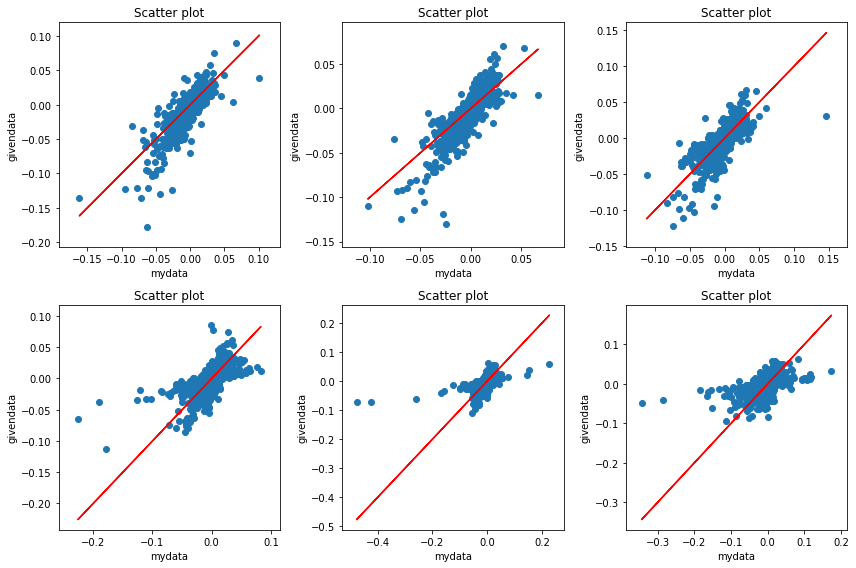

   Maturities  Correlations
0          30      0.856266
1          60      0.870863
2          90      0.796195
3         180      0.660793
4         270      0.545001
5         360      0.563972


In [65]:
# compare the returns to his give dataset for the returns of the short straddles
file_path_4 = 'Data/STRADDLE_RET.csv'
data_4 = pd.read_csv(file_path_4,skiprows=6)
def DATE_STR(num):
    num_str = str(num)
    date_str = num_str[-2:]+'/'+num_str[4:-2]+'/'+num_str[0:4]
    
    return date_str 

#data_2['Date'] = data_2['Date'].apply(DATE_STR)
data_4['Date'] = pd.to_datetime(data_4['Date'], format='%Y%m%d').dt.strftime('%Y-%m-%d')
data_4[data_4.columns[1:]] = data_4[data_4.columns[1:]]/100
merged_data = pd.merge(merged_results, data_4, on='Date', how='inner')

result_1 = merged_data[['Date', 'r_v_30', 'r_1^{short straddle}']]
result_2 = merged_data[['Date', 'r_v_60', 'r_2^{short straddle}']]
result_3 = merged_data[['Date', 'r_v_90', 'r_3^{short straddle}']]
result_6 = merged_data[['Date', 'r_v_180', 'r_6^{short straddle}']]
result_9 = merged_data[['Date', 'r_v_270', 'r_9^{short straddle}']]
result_12 = merged_data[['Date', 'r_v_360', 'r_12^{short straddle}']]
resultlist = [result_1, result_2, result_3, result_6, result_9, result_12]

#plot and get correlation
# Assuming resultlist is a list of DataFrames
# Calculate the number of plots to create
num_plots = len(resultlist)

# Calculate the number of rows and columns for subplots
num_cols = 3  # Number of plots to display in a row
num_rows = - (-num_plots // num_cols)  # Rounds up the division to the nearest whole number

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows))  # Adjust figsize as needed

# Flatten the axes if the number of subplots is less than num_rows x num_cols
axes = axes.flatten()

for i in range(num_plots):
    result = resultlist[i]
    ax = axes[i]
    ax.scatter(result.iloc[:, 1], result.iloc[:, 2])
    ax.plot(result.iloc[:, 1], result.iloc[:, 1], color='red')  # Line for correlation = 1
    ax.set_xlabel('mydata')
    ax.set_ylabel('givendata')
    ax.set_title('Scatter plot')

# Hide empty subplots if the number of plots doesn't fill all the subplots
for i in range(num_plots, num_rows * num_cols):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Calculate correlation
correlation1 = result_1['r_v_30'].corr(result_1['r_1^{short straddle}'])
correlation2 = result_2['r_v_60'].corr(result_2['r_2^{short straddle}'])
correlation3 = result_3['r_v_90'].corr(result_3['r_3^{short straddle}'])
correlation6 = result_6['r_v_180'].corr(result_6['r_6^{short straddle}'])
correlation9 = result_9['r_v_270'].corr(result_9['r_9^{short straddle}'])
correlation12 = result_12['r_v_360'].corr(result_12['r_12^{short straddle}'])
data = {
    'Maturities': [30, 60, 90, 180, 270, 360],
    'Correlations': [correlation1, correlation2, correlation3, correlation6, correlation9,correlation12]
}

# Create a DataFrame
df = pd.DataFrame(data)
print(df)

## Start here with importing the data!
Here, the analysis of the investment strategy starts.

In [68]:
# Import our data
#File paths for the CSV files
file_path = 'Data/Straddles/short_straddle_returns_correct.csv'
# Reading the CSV files into Pandas DataFrames
STRADDLE_RET = pd.read_csv(file_path)

In [69]:
# Import his data for comparison
# File paths for the CSV files
file_path = 'Data/STRADDLE_RET.csv'

# Reading the CSV files into Pandas DataFrames
STRADDLE_RET_given = pd.read_csv(file_path, skiprows=6)
STRADDLE_RET_given['Date'] = pd.to_datetime(STRADDLE_RET_given['Date'], format='%Y%m%d').dt.strftime('%Y-%m-%d')
STRADDLE_RET_given[STRADDLE_RET_given.columns[1:]] = STRADDLE_RET_given[STRADDLE_RET_given.columns[1:]]/100
# his given returns include long and short returns (name differ accordingly)

,Date,r_1^{straddle},r_2^{straddle},r_3^{straddle},r_6^{straddle},r_9^{straddle},r_12^{straddle},r_1^{short straddle},r_2^{short straddle},r_3^{short straddle},r_6^{short straddle},r_9^{short straddle},r_12^{short straddle}
0,1996-01-05,-0.04067,0.00827,0.01018,-0.00307,-0.00067,0.00855,0.00500,-0.00145,-0.00221,0.00101,0.00029,-0.00428
1,1996-01-08,-0.01795,-0.00642,-0.00443,0.00307,0.00234,0.00167,0.00224,0.00116,0.00098,-0.00101,-0.00101,-0.00085
2,1996-01-09,0.34233,0.09657,0.04109,-0.00396,-0.00324,0.04148,-0.04098,-0.01743,-0.00916,0.00132,0.00141,-0.02104
3,1996-01-10,0.00968,-0.02854,-0.01956,0.00723,-0.00770,-0.05758,-0.00139,0.00597,0.00482,-0.00246,0.00340,0.03095
4,1996-01-11,-0.09191,-0.06238,-0.03260,0.01116,-0.01824,-0.01151,0.01410,0.01363,0.00842,-0.00404,0.00835,0.00594
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5906,2019-06-24,-0.05374,-0.04033,-0.03600,-0.02177,-0.01651,-0.01243,0.00788,0.00891,0.01000,0.00881,0.00830,0.00737
5907,2019-06-25,0.02155,0.00807,0.00500,0.00085,-0.00032,-0.00239,-0.00323,-0.00178,-0.00138,-0.00034,0.00016,0.00141
5908,2019-06-26,-0.03581,-0.02534,-0.01805,-0.00796,-0.00470,-0.00463,0.00578,0.00589,0.00519,0.00330,0.00241,0.00280
5909,2019-06-27,-0.01815,-0.01095,-0.00674,-0.00433,-0.00369,-0.00283,0.00292,0.00252,0.00193,0.00179,0.00190,0.00171


In [70]:
# produce a graph with the cumulative performance of unconditionally shorting the straddles
# Calculate cumulative performance starting from 1 at the first date (1996-01-05)
STRADDLE_RET['cumulative_performance_1'] = (1 + STRADDLE_RET['r_v_30']).cumprod()
STRADDLE_RET['cumulative_performance_2'] = (1 + STRADDLE_RET['r_v_60']).cumprod()
STRADDLE_RET['cumulative_performance_3'] = (1 + STRADDLE_RET['r_v_90']).cumprod()
STRADDLE_RET['cumulative_performance_6'] = (1 + STRADDLE_RET['r_v_180']).cumprod()
STRADDLE_RET['cumulative_performance_9'] = (1 + STRADDLE_RET['r_v_270']).cumprod()
STRADDLE_RET['cumulative_performance_12'] = (1 + STRADDLE_RET['r_v_360']).cumprod()
# same for his data
STRADDLE_RET_given['cumulative_performance_1'] = (1 + STRADDLE_RET_given['r_1^{short straddle}']).cumprod()
STRADDLE_RET_given['cumulative_performance_2'] = (1 + STRADDLE_RET_given['r_2^{short straddle}']).cumprod()
STRADDLE_RET_given['cumulative_performance_3'] = (1 + STRADDLE_RET_given['r_3^{short straddle}']).cumprod()
STRADDLE_RET_given['cumulative_performance_6'] = (1 + STRADDLE_RET_given['r_6^{short straddle}']).cumprod()
STRADDLE_RET_given['cumulative_performance_9'] = (1 + STRADDLE_RET_given['r_9^{short straddle}']).cumprod()
STRADDLE_RET_given['cumulative_performance_12'] = (1 + STRADDLE_RET_given['r_12^{short straddle}']).cumprod()

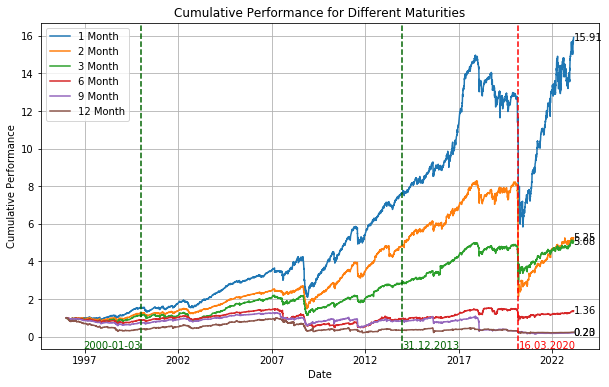

In [77]:
# Plotting the cumulative performances for our data
plt.figure(figsize=(10, 6))
maturity_columns = [1, 2, 3, 6, 9, 12]
STRADDLE_RET['Date'] = pd.to_datetime(STRADDLE_RET['Date'])
# Plot each line for different durations
for mat in maturity_columns:
    plt.plot(STRADDLE_RET['Date'], STRADDLE_RET[f'cumulative_performance_{mat}'], label=f'{mat} Month')

    # Add text annotations for the end value of each line
    end_value = STRADDLE_RET[f'cumulative_performance_{mat}'].iloc[-1]
    plt.text(STRADDLE_RET['Date'].iloc[-1], end_value, f'{end_value:.2f}', va='center', ha='left')

years = pd.date_range(start='1996-01-05', end='2022-01-05', freq='5YS')  # Generating year starts
plt.xticks(years, [year.year for year in years])

plt.axvline(pd.to_datetime('2013-12-31'), color='darkgreen', linestyle='--')
plt.text(pd.to_datetime('2013-12-31'), plt.gca().get_ylim()[0], '31.12.2013', color='darkgreen', ha='left')
plt.axvline(pd.to_datetime('2000-01-03'), color='darkgreen', linestyle='--')
plt.text(pd.to_datetime('2000-01-03'), plt.gca().get_ylim()[0], '2000-01-03', color='darkgreen', ha='right')
plt.axvline(pd.to_datetime('2020-03-16'), color='red', linestyle='--')
plt.text(pd.to_datetime('2020-03-16'), plt.gca().get_ylim()[0], '16.03.2020', color='red', ha='left')

plt.title('Cumulative Performance for Different Maturities')
plt.xlabel('Date')
plt.ylabel('Cumulative Performance')
plt.legend()
plt.grid(True)
plt.show()

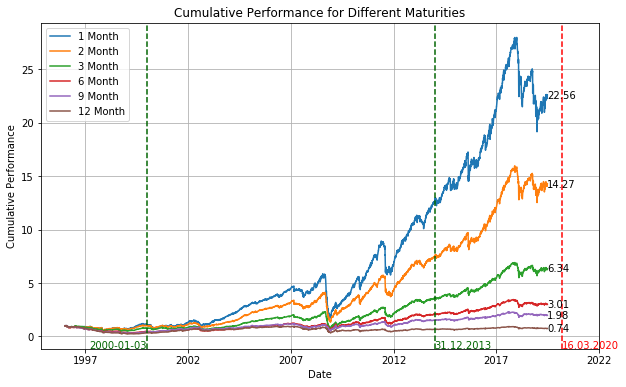

In [76]:
# Plotting the cumulative performances for his data
plt.figure(figsize=(10, 6))
maturity_columns = [1, 2, 3, 6, 9, 12]
STRADDLE_RET_given['Date'] = pd.to_datetime(STRADDLE_RET_given['Date'])
# Plot each line for different durations
for mat in maturity_columns:
    plt.plot(STRADDLE_RET_given['Date'], STRADDLE_RET_given[f'cumulative_performance_{mat}'], label=f'{mat} Month')

    # Add text annotations for the end value of each line
    end_value = STRADDLE_RET_given[f'cumulative_performance_{mat}'].iloc[-1]
    plt.text(STRADDLE_RET_given['Date'].iloc[-1], end_value, f'{end_value:.2f}', va='center', ha='left')

years = pd.date_range(start='1996-01-05', end='2022-01-05', freq='5YS')  # Generating year starts
plt.xticks(years, [year.year for year in years])

plt.axvline(pd.to_datetime('2013-12-31'), color='darkgreen', linestyle='--')
plt.text(pd.to_datetime('2013-12-31'), plt.gca().get_ylim()[0], '31.12.2013', color='darkgreen', ha='left')
plt.axvline(pd.to_datetime('2000-01-03'), color='darkgreen', linestyle='--')
plt.text(pd.to_datetime('2000-01-03'), plt.gca().get_ylim()[0], '2000-01-03', color='darkgreen', ha='right')
plt.axvline(pd.to_datetime('2020-03-16'), color='red', linestyle='--')
plt.text(pd.to_datetime('2020-03-16'), plt.gca().get_ylim()[0], '16.03.2020', color='red', ha='left')

plt.title('Cumulative Performance for Different Maturities')
plt.xlabel('Date')
plt.ylabel('Cumulative Performance')
plt.legend()
plt.grid(True)
plt.show()
#his dataset is only until 2019

One can clearly see that we are unfortunately need able to replicate his data 1:1. The characteristics, however, look to be the same.
Again, in the paper, the performance graph start at the beginning of 2000 and only leads to end 2013. See the period in darkgreen. To actually compare it though, one would need to recalculate the full performance to start at 1 in the beginning of 2000.

# Now to the conditional performance of the strategy
Conditional strategy using SLOPE as an indicator for whether to buy or sell straddles.
For 1996 - 1999 training period:
Compute SLOPE_t using PCA on VIX term structure data from beginning of sample to t
If SLOPE_t in bottom quintile of historical distribution, buy straddles at t, sell at t+1. Otherwise, short at t, buy             back at t+1. Watch out for the look ahead bias!!!
Should be substantially positive --> make graph, calculate sharpe ratio, average return and volatility
The paper uses a training (in-sample) and testperiod (out-of-sample) for the conditional strategy, and the graph is just from beginning of 2000 to 2013 (even though data would have been available up until 2019).

In this next session, I am only working with the 30 day data. The codes can however just be reused for other maturities

In [79]:
# File paths for the CSV files (currently the one given by him, change this once it is available)
file_path = 'Data/PCA.csv'

# Reading the CSV files into Pandas DataFrames and only store the column that is needed for the conditional strategy (Slope)
PCA = pd.read_csv(file_path,skiprows = 12)
PCA.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
PCA = PCA.drop(['Unnamed: 7'], axis=1)
PCA['Date'] = pd.to_datetime(PCA['Date'], format='%Y%m%d').dt.strftime('%Y-%m-%d')
SLOPE = PCA[['Date', 'PC2']].copy()
SLOPE.rename(columns={'PC2': 'Slope'}, inplace=True)


In [80]:
# Here, the actual signal is collected
# I get the signal from continously comparing the current value of slope to the historical distribution UP TO t. 
# So in my opinion, there is no need to split up the dataset into training and test data.

# Replace or drop missing values in the 'Slope' column
SLOPE['Slope'].fillna(method='ffill', inplace=True)  # Forward fill NaN values
# Convert 'Date' column to datetime if it's not already in datetime format
SLOPE['Date'] = pd.to_datetime(SLOPE['Date'])

# Initialize a list to hold the boolean values for each row
in_bottom_quintile = []

# Calculate quantile based on historical data up until date 't' for each observation
for i in range(len(SLOPE)):
    # Select the data up to the current row's date
    slope_data = SLOPE.loc[SLOPE['Date'] <= SLOPE.iloc[i]['Date']]
    #print(i)
    #print("Slope: ",slope_data)
    if len(slope_data) > 1:
        current_value = slope_data.iloc[-1]['Slope']
        #print("Current value: ", current_value)
        historical_values = slope_data.iloc[:-1]['Slope']
        #print("Historical values: ", historical_values)
        quantile = historical_values.quantile(0.2)
        #print('Quantile: ', quantile)
        in_bottom_quintile.append(current_value <= quantile)
        #print(f"True/False_{i}: ", in_bottom_quintile)
    else:
        in_bottom_quintile.append(True)  # Set as True if insufficient data for quantile calculation

# Assign the list to a new column 'InBottomQuintile'
SLOPE['InBottomQuintile'] = in_bottom_quintile


In [81]:
# Now, we still need to get the long straddle returns from our data (his given ones are already stored)
# File paths for the CSV files
file_path = 'Data/Straddles/straddle_returns_incorrect.csv' 
#straddle_returns_correct is with the correct weighting, _final with the wrong (which is closer to his data)
# Reading the CSV files into Pandas DataFrames
returns_long = pd.read_csv(file_path)
returns_long = returns_long.rename(columns={'date': 'Date'})

In [83]:
# SLOPE['Date'] = pd.to_datetime(SLOPE['Date']) done above already
returns_long['Date'] = pd.to_datetime(returns_long['Date'])
#STRADDLE_RET['Date'] = pd.to_datetime(STRADDLE_RET['Date']) applied above already
#merge the datasets
returns_long_short_30 = pd.merge(returns_long[['Date', 'return_30']], STRADDLE_RET[['Date','r_v_30']], on='Date', how='inner')
returns_long_short_30 = returns_long_short_30.merge(SLOPE[['Date', 'InBottomQuintile']], on='Date')
#shift to account for the look ahead bias
returns_long_short_30['InBottomQuintile'] = returns_long_short_30['InBottomQuintile'].shift(1)
returns_long_short_30['InBottomQuintile'][0] = True #set first value manually

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [84]:
# Condition: If the 'InBottomQuintile' is True, use 'return_30', otherwise 'r_v_30'
condition = returns_long_short_30.apply(lambda row: row['return_30'] if row['InBottomQuintile'] else row['r_v_30'], axis=1)

# Calculate cumulative returns based on the condition
cumulative_return = (1 + condition).cumprod()
returns_long_short_30['cumulative_returns'] = cumulative_return
returns_long_short_30

,Date,return_30,r_v_30,InBottomQuintile,cumulative_returns
0,1996-01-05,-0.047362,0.002855,True,0.952638
1,1996-01-08,-0.050125,0.003020,False,0.955514
2,1996-01-09,0.352578,-0.020640,False,0.935792
3,1996-01-10,0.120899,-0.008543,True,1.048929
4,1996-01-11,-0.096908,0.007298,True,0.947280
...,...,...,...,...,...
5903,2019-06-24,-0.053542,0.003957,False,44.955852
5904,2019-06-25,0.020247,-0.001429,False,44.891590
5905,2019-06-26,-0.035831,0.002890,False,45.021308
5906,2019-06-27,-0.016247,0.001278,False,45.078827


In [36]:
# To check: When the data is cropped at the end of 2013
#STRADDLE_RET = STRADDLE_RET[STRADDLE_RET['Date'] <= pd.to_datetime('2013-12-31')]
#returns_long_short_30 = returns_long_short_30[returns_long_short_30['Date'] <= pd.to_datetime('2013-12-31')]

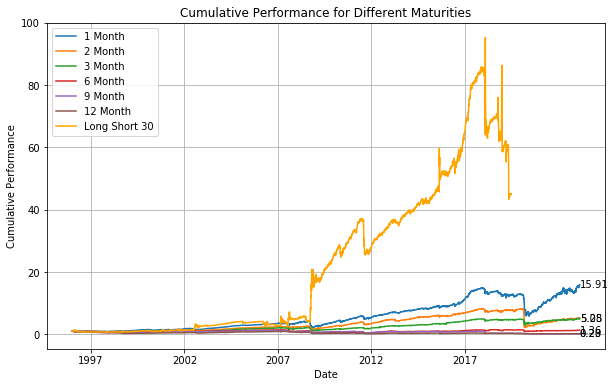

In [86]:
# Plotting the cumulative performances
plt.figure(figsize=(10, 6))
maturity_columns = [1, 2, 3, 6, 9, 12]

# Plot each line for different durations
for mat in maturity_columns:
    plt.plot(STRADDLE_RET['Date'], STRADDLE_RET[f'cumulative_performance_{mat}'], label=f'{mat} Month')

    # Add text annotations for the end value of each line
    end_value = STRADDLE_RET[f'cumulative_performance_{mat}'].iloc[-1]
    plt.text(STRADDLE_RET['Date'].iloc[-1], end_value, f'{end_value:.2f}', va='center', ha='left')

# Add the line from 'returns_long_short_30'
plt.plot(returns_long_short_30['Date'], returns_long_short_30['cumulative_returns'], color='orange', label='Long Short 30')

#STRADDLE_RET['Date'] = pd.to_datetime(STRADDLE_RET['Date']) applied above
years = pd.date_range(start='1996-01-05', end='2019-12-31', freq='5YS')  # Generating year starts
plt.xticks(years, [year.year for year in years])

#plt.axvline(pd.to_datetime('2020-03-16'), color='red', linestyle='--', label='16.03.2020')
#plt.axvline(pd.to_datetime('2020-03-16'), color='red', linestyle='--')
#plt.text(pd.to_datetime('2020-03-16'), plt.gca().get_ylim()[0], '16.03.2020', color='red', ha='left')

plt.title('Cumulative Performance for Different Maturities')
plt.xlabel('Date')
plt.ylabel('Cumulative Performance')
plt.legend()
plt.grid(True)
# Show the modified plot
plt.show()

This actually looks comparable to his graph, when cropped of in 2013 and the y-axis is manipulated.
Still, to compare, the same codes are used on his data to compare.

In [87]:
# using his data
SLOPE['Date'] = pd.to_datetime(SLOPE['Date'])
returns_long_short_30 = STRADDLE_RET_given[['Date', 'r_1^{straddle}', 'r_1^{short straddle}']]
returns_long_short_30 = returns_long_short_30.merge(SLOPE[['Date', 'InBottomQuintile']], on='Date')
returns_long_short_30['InBottomQuintile'] = returns_long_short_30['InBottomQuintile'].shift(1)
returns_long_short_30['InBottomQuintile'][0] = True
print(returns_long_short_30)
# somethin must be wrong here for sure, because
# Condition: If the 'condition_column' is True, use 'return_30', otherwise 'r_v_30'
condition = returns_long_short_30.apply(lambda row: row['r_1^{straddle}'] if row['InBottomQuintile'] else row['r_1^{short straddle}'], axis=1)
print(condition)
# Calculate cumulative returns based on the condition
cumulative_return = (1 + condition).cumprod()
print(cumulative_return)
returns_long_short_30['cumulative_returns'] = cumulative_return
returns_long_short_30

           Date  r_1^{straddle}  r_1^{short straddle} InBottomQuintile
0    1996-01-05        -0.04067               0.00500             True
1    1996-01-08        -0.01795               0.00224            False
2    1996-01-09         0.34233              -0.04098            False
3    1996-01-10         0.00968              -0.00139             True
4    1996-01-11        -0.09191               0.01410             True
...         ...             ...                   ...              ...
5906 2019-06-24        -0.05374               0.00788            False
5907 2019-06-25         0.02155              -0.00323            False
5908 2019-06-26        -0.03581               0.00578            False
5909 2019-06-27        -0.01815               0.00292            False
5910 2019-06-28        -0.00534               0.00083            False

[5911 rows x 4 columns]
0      -0.04067
1       0.00224
2      -0.04098
3       0.00968
4      -0.09191
         ...   
5906    0.00788
5907   -0.0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Date,r_1^{straddle},r_1^{short straddle},InBottomQuintile,cumulative_returns
0,1996-01-05,-0.04067,0.00500,True,0.959330
1,1996-01-08,-0.01795,0.00224,False,0.961479
2,1996-01-09,0.34233,-0.04098,False,0.922077
3,1996-01-10,0.00968,-0.00139,True,0.931003
4,1996-01-11,-0.09191,0.01410,True,0.845435
...,...,...,...,...,...
5906,2019-06-24,-0.05374,0.00788,False,183.336141
5907,2019-06-25,0.02155,-0.00323,False,182.743965
5908,2019-06-26,-0.03581,0.00578,False,183.800225
5909,2019-06-27,-0.01815,0.00292,False,184.336922


In [90]:
returns_long_short_30['InBottomQuintile'].mean()
STRADDLE_RET_given

,Date,r_1^{straddle},r_2^{straddle},r_3^{straddle},r_6^{straddle},r_9^{straddle},r_12^{straddle},r_1^{short straddle},r_2^{short straddle},r_3^{short straddle},r_6^{short straddle},r_9^{short straddle},r_12^{short straddle},cumulative_performance_1,cumulative_performance_2,cumulative_performance_3,cumulative_performance_6,cumulative_performance_9,cumulative_performance_12
0,1996-01-05,-0.04067,0.00827,0.01018,-0.00307,-0.00067,0.00855,0.00500,-0.00145,-0.00221,0.00101,0.00029,-0.00428,1.005000,0.998550,0.997790,1.001010,1.000290,0.995720
1,1996-01-08,-0.01795,-0.00642,-0.00443,0.00307,0.00234,0.00167,0.00224,0.00116,0.00098,-0.00101,-0.00101,-0.00085,1.007251,0.999708,0.998768,0.999999,0.999280,0.994874
2,1996-01-09,0.34233,0.09657,0.04109,-0.00396,-0.00324,0.04148,-0.04098,-0.01743,-0.00916,0.00132,0.00141,-0.02104,0.965974,0.982283,0.989619,1.001319,1.000689,0.973941
3,1996-01-10,0.00968,-0.02854,-0.01956,0.00723,-0.00770,-0.05758,-0.00139,0.00597,0.00482,-0.00246,0.00340,0.03095,0.964631,0.988148,0.994389,0.998856,1.004091,1.004085
4,1996-01-11,-0.09191,-0.06238,-0.03260,0.01116,-0.01824,-0.01151,0.01410,0.01363,0.00842,-0.00404,0.00835,0.00594,0.978233,1.001616,1.002762,0.994820,1.012475,1.010049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5906,2019-06-24,-0.05374,-0.04033,-0.03600,-0.02177,-0.01651,-0.01243,0.00788,0.00891,0.01000,0.00881,0.00830,0.00737,22.419205,14.153947,6.280989,2.995562,1.968641,0.738368
5907,2019-06-25,0.02155,0.00807,0.00500,0.00085,-0.00032,-0.00239,-0.00323,-0.00178,-0.00138,-0.00034,0.00016,0.00141,22.346791,14.128753,6.272321,2.994544,1.968956,0.739410
5908,2019-06-26,-0.03581,-0.02534,-0.01805,-0.00796,-0.00470,-0.00463,0.00578,0.00589,0.00519,0.00330,0.00241,0.00280,22.475956,14.211971,6.304875,3.004426,1.973701,0.741480
5909,2019-06-27,-0.01815,-0.01095,-0.00674,-0.00433,-0.00369,-0.00283,0.00292,0.00252,0.00193,0.00179,0.00190,0.00171,22.541585,14.247785,6.317043,3.009804,1.977451,0.742748


In [88]:
# cropping the dataframes
#STRADDLE_RET = STRADDLE_RET[STRADDLE_RET['Date'] <= pd.to_datetime('2012-12-31')]
#returns_long_short_30 = returns_long_short_30[returns_long_short_30['Date'] <= pd.to_datetime('2012-12-31')]

TypeError: '<=' not supported between instances of 'str' and 'Timestamp'

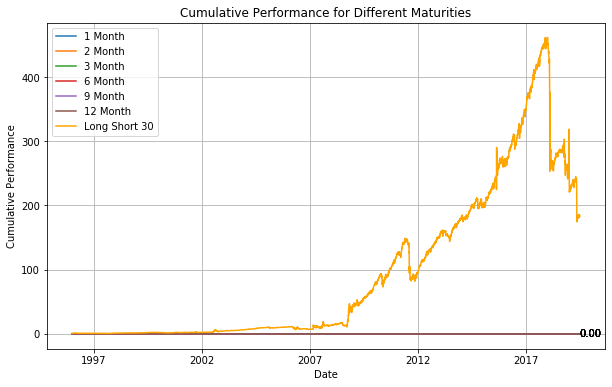

In [92]:
# Plotting the cumulative performances
#this is not finished yet and still needs some working!
plt.figure(figsize=(10, 6))
maturity_columns = [1, 2, 3, 6, 9, 12]

# Plot each line for different durations
for mat in maturity_columns:
    plt.plot(STRADDLE_RET_given['Date'], STRADDLE_RET_given[f'r_{mat}^'+'{short straddle}'], label=f'{mat} Month')

    # Add text annotations for the end value of each line
    end_value = STRADDLE_RET_given[f'r_{mat}^'+'{short straddle}'].iloc[-1]
    plt.text(STRADDLE_RET_given['Date'].iloc[-1], end_value, f'{end_value:.2f}', va='center', ha='left')

# Add the line from 'returns_long_short_30'
plt.plot(returns_long_short_30['Date'], returns_long_short_30['cumulative_returns'], color='orange', label='Long Short 30')

#STRADDLE_RET_given['Date'] = pd.to_datetime(STRADDLE_RET_given['Date'])
years = pd.date_range(start='1996-01-05', end='2019-12-31', freq='5YS')  # Generating year starts
plt.xticks(years, [year.year for year in years])

#plt.axvline(pd.to_datetime('2020-03-16'), color='red', linestyle='--', label='16.03.2020')
#plt.axvline(pd.to_datetime('2020-03-16'), color='red', linestyle='--')
#plt.text(pd.to_datetime('2020-03-16'), plt.gca().get_ylim()[0], '16.03.2020', color='red', ha='left')

plt.title('Cumulative Performance for Different Maturities')
plt.xlabel('Date')
plt.ylabel('Cumulative Performance')
plt.legend()
plt.grid(True)
# Show the modified plot
plt.show()

In [55]:
returns_long_short_30.loc[returns_long_short_30['Date'] == '2000-01-03']

,Date,r_1^{straddle},r_1^{short straddle},InBottomQuintile,cumulative_returns
1008,2000-01-03,-0.07918,0.01861,False,2.209046
